<a href="https://colab.research.google.com/github/seoharu/DATA-AI/blob/main/covid19_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

In [29]:
!wget 'https://anaconda.org/conda-forge/gdcm/2.8.9/download/linux-64/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -q
!conda install '/content/gdcm-2.8.9-py37h500ead1_1.tar.bz2 -c conda-forge -y

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
os.environ['KAGGLE_USERNAME'] = 'syunseul'
os.environ['KAGGLE_KEY'] = 'b8eb2915a893051a828269b5271f3245'

In [33]:
import matplotlib.pyplot as plt
import matplotlib
#import pydicom as dicom
import cv2
import ast
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load Data

In [34]:
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...

options:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        kernels {list, init, push, pull, output, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    files (f)           Commands related files
    config              Configuration settings


In [45]:
!kaggle datasets download -d kaggle competitions download -c siim-covid19-detection

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: unrecognized arguments: download -c siim-covid19-detection


In [46]:
path = '/kaggle/input/siim-covid19-detection/'

In [48]:
path

'/kaggle/input/siim-covid19-detection/'

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip 'train.zip'

In [ ]:
!unzip 'test.zip'

In [22]:
train_image = pd.read_csv('/content/train_image_level.csv')
train_study = pd.read_csv('/content/train_study_level.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [23]:
len(sample_submission)

2477

In [24]:
train_image

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


In [25]:
train_study

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


In [ ]:
# Read DCM File

In [26]:
temp = train_image.loc[0, 'StudyInstanceUID']
temp

'5776db0cec75'

In [51]:
temp_depth2 = ('train/'+temp)
temp_depth2[0]

't'

In [52]:
temp_train_path = 'train/'+temp+'/'+temp_depth2[0]
temp_train_path

'train/5776db0cec75/t'

In [53]:
train_image.loc[0, 'id']

'000a312787f2_image'

In [ ]:
# make image extractor(function)

In [54]:
def extraction(i):
    path_train = 'train/' + train_image.loc[i, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = train_image.loc[i, 'id'].replace('_image','.dcm')
    print(img_id)
    data_file = dicom.dcmread(path_train+img_id)
    img = data_file.pixel_array
    return img

In [24]:
#show sample image

In [55]:
sample_img = extraction

In [56]:
sample_img

<function __main__.extraction(i)>

In [57]:
train_image.loc[0, 'boxes']

"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]"

In [58]:
boxes = ast.literal_eval(train_image.loc[0, 'boxes'])
boxes

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292},
 {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]

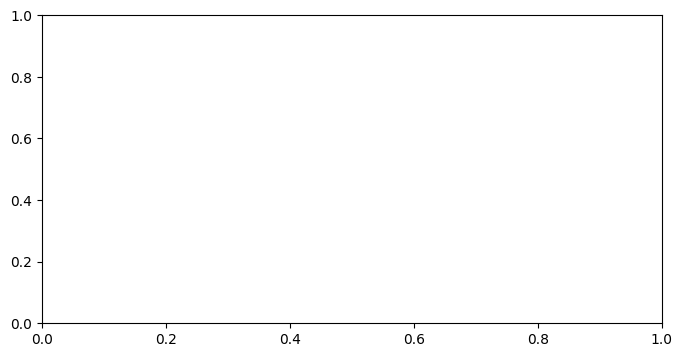

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for box in boxes:
  p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='r', fc='none', lw=1.5)
  ax.add_patch(p)
#ax.imshow(sample_img, cmap='gray')
#plt.show()

TypeError: ignored

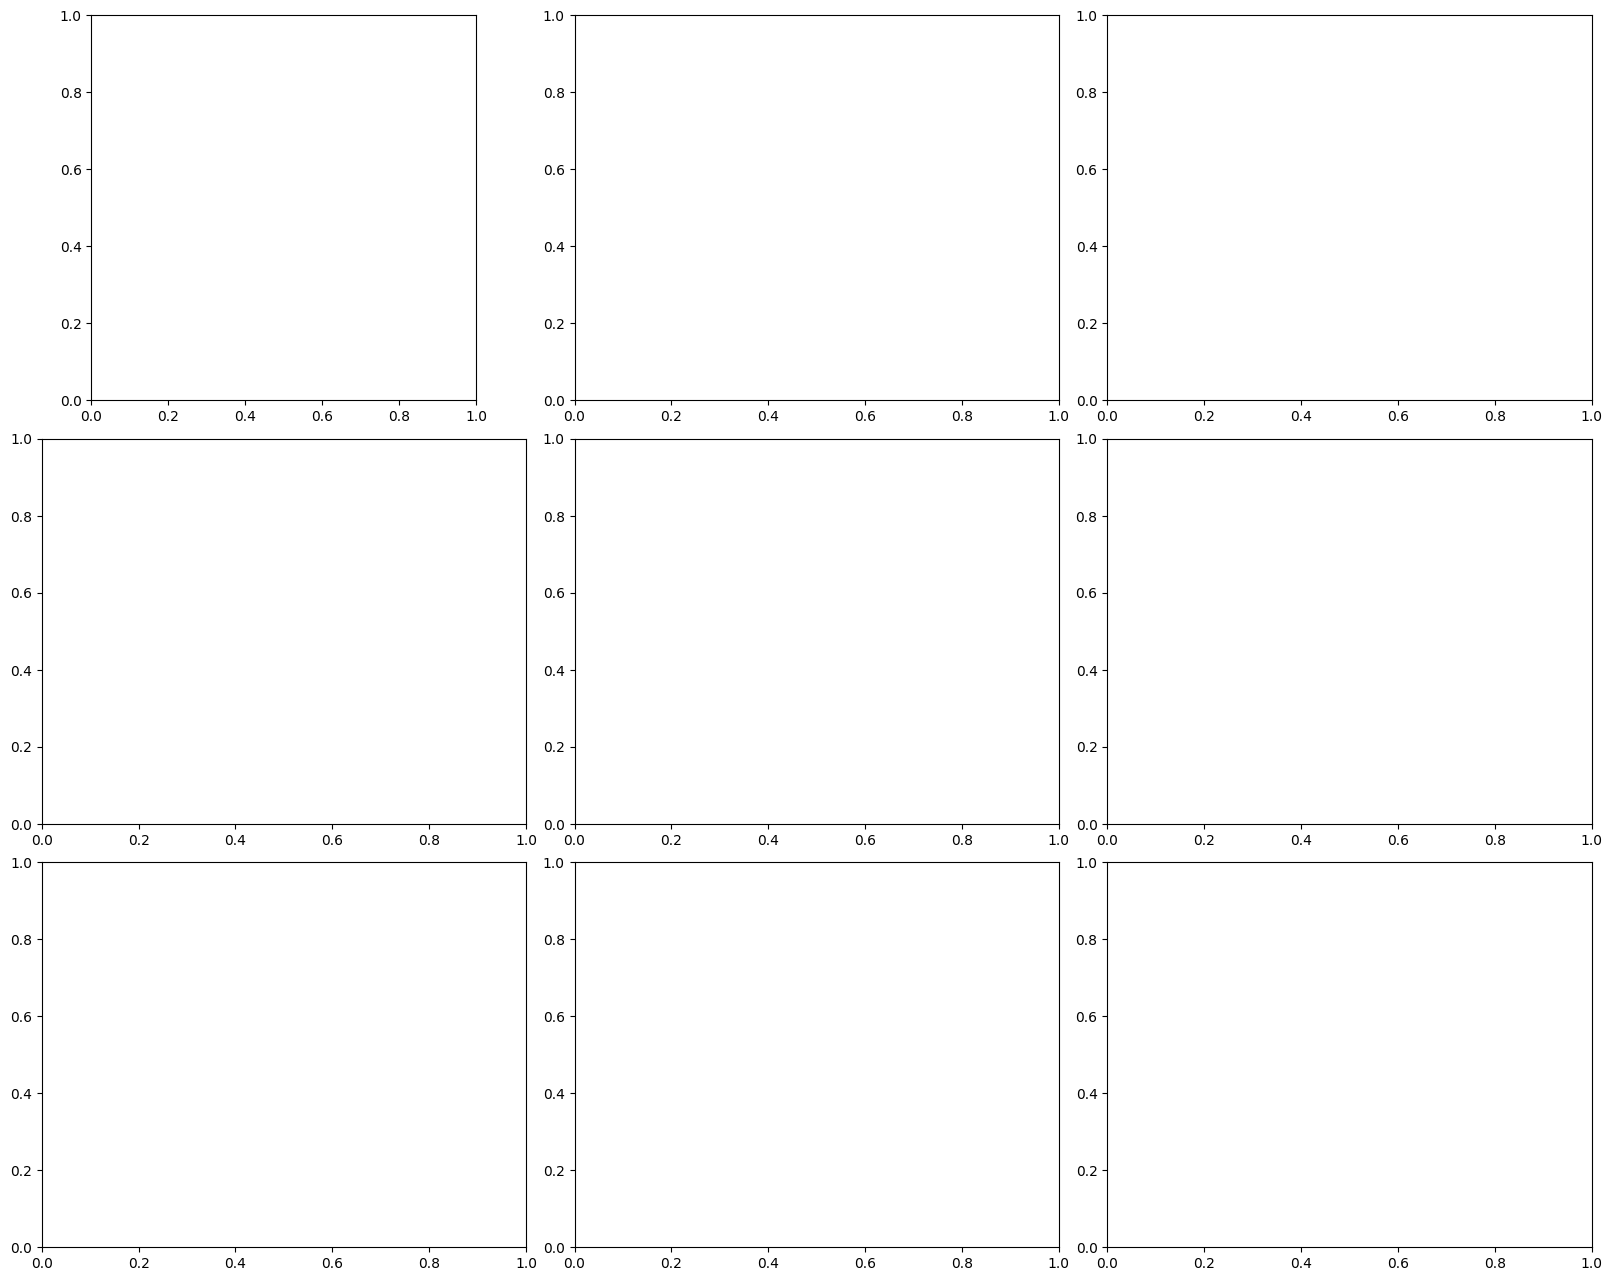

In [63]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()

for row in range(9):
    img = extraction(row)
    # if (nan == nan)
    # False
    if (train_image.loc[row,'boxes'] == train_image.loc[row,'boxes']):
        boxes = ast.literal_eval(train_image.loc[row,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)

    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_image.loc[row, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])

In [ ]:
# feature engineering

In [64]:
train_image

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


In [65]:
OpacityCount = train_image['label'].str.count('opacity')
OpacityCount

0       2
1       0
2       2
3       1
4       2
       ..
6329    0
6330    0
6331    3
6332    2
6333    2
Name: label, Length: 6334, dtype: int64

In [66]:
train_image['OpacityCount'] = OpacityCount.values

In [67]:
train_image

,id,boxes,label,StudyInstanceUID,OpacityCount
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2
...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,3
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,2


In [68]:
train_image['id'].isnull().sum()

0

In [69]:
id_extract = lambda x : x[0]

In [70]:
train_study

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


In [71]:
train_study['id'].isnull().sum()

0

In [72]:
train_study['id'].str.split('_')

0       [00086460a852, study]
1       [000c9c05fd14, study]
2       [00292f8c37bd, study]
3       [005057b3f880, study]
4       [0051d9b12e72, study]
                ...          
6049    [ffcb4630f46f, study]
6050    [ffe4d6e8fbb0, study]
6051    [ffe94fcb14fa, study]
6052    [ffebf1ef4a9c, study]
6053    [fff649d65f62, study]
Name: id, Length: 6054, dtype: object

In [73]:
train_study['id'].str.split('_').apply(id_extract)

0       00086460a852
1       000c9c05fd14
2       00292f8c37bd
3       005057b3f880
4       0051d9b12e72
            ...     
6049    ffcb4630f46f
6050    ffe4d6e8fbb0
6051    ffe94fcb14fa
6052    ffebf1ef4a9c
6053    fff649d65f62
Name: id, Length: 6054, dtype: object

In [74]:
train_study['id'] = train_study['id'].str.split('_').apply(id_extract)

In [75]:
sum(train_study['id'].str.contains(train_image['StudyInstanceUID'][0]))

1

In [76]:
train_study = train_study.rename({'id':'StudyInstanceUID'}, axis=1)

In [77]:
train_study

,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f,0,1,0,0
6050,ffe4d6e8fbb0,0,1,0,0
6051,ffe94fcb14fa,0,1,0,0
6052,ffebf1ef4a9c,0,1,0,0


In [78]:
train_df = pd.merge(train_image, train_study, on='StudyInstanceUID')
train_df

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,0,1,0,0,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,3,0,1,0,0
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,2,0,1,0,0


In [79]:
train_df['OpacityCount'].value_counts()

2    3113
0    2040
1     973
3     183
4      23
5       1
8       1
Name: OpacityCount, dtype: int64

In [80]:
train_df.iloc[:,5:].columns

Index(['Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance'],
      dtype='object')

In [81]:
i = 5
for col in train_df.iloc[:,5:].columns:
    print('The Count of {} : '.format(col), sum(train_df.iloc[:,i]))
    i += 1

The Count of Negative for Pneumonia :  1736
The Count of Typical Appearance :  3007
The Count of Indeterminate Appearance :  1108
The Count of Atypical Appearance :  483


In [82]:
train_df[train_df['OpacityCount'] == 0]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0
6,0023f02ae886_image,NaN,none 1 0 0 1 1,2fa400b873f5,0,1,0,0,0
22,00c1515729a8_image,NaN,none 1 0 0 1 1,1a58b43cf286,0,0,1,0,0
25,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
6322,ff7659762b75_image,NaN,none 1 0 0 1 1,4aa11ef1fd38,0,1,0,0,0
6324,ff9f10a24c27_image,NaN,none 1 0 0 1 1,a937614104e3,0,1,0,0,0
6325,ffa9fef3c7bf_image,NaN,none 1 0 0 1 1,5133bbb7b75c,0,1,0,0,0
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0


In [83]:
OCount = sorted(list(train_df['OpacityCount'].value_counts().index))
print(OCount)

[0, 1, 2, 3, 4, 5, 8]


In [84]:
for count in OCount:
    print('Opacity Count = {}\n------------------------------'.format(count))
    print(train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum())
    print(' ')

Opacity Count = 0
------------------------------
Negative for Pneumonia      1736
Typical Appearance           153
Indeterminate Appearance      59
Atypical Appearance           92
dtype: int64
 
Opacity Count = 1
------------------------------
Negative for Pneumonia        0
Typical Appearance           27
Indeterminate Appearance    685
Atypical Appearance         261
dtype: int64
 
Opacity Count = 2
------------------------------
Negative for Pneumonia         0
Typical Appearance          2653
Indeterminate Appearance     345
Atypical Appearance          115
dtype: int64
 
Opacity Count = 3
------------------------------
Negative for Pneumonia        0
Typical Appearance          152
Indeterminate Appearance     17
Atypical Appearance          14
dtype: int64
 
Opacity Count = 4
------------------------------
Negative for Pneumonia       0
Typical Appearance          21
Indeterminate Appearance     1
Atypical Appearance          1
dtype: int64
 
Opacity Count = 5
------------------

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

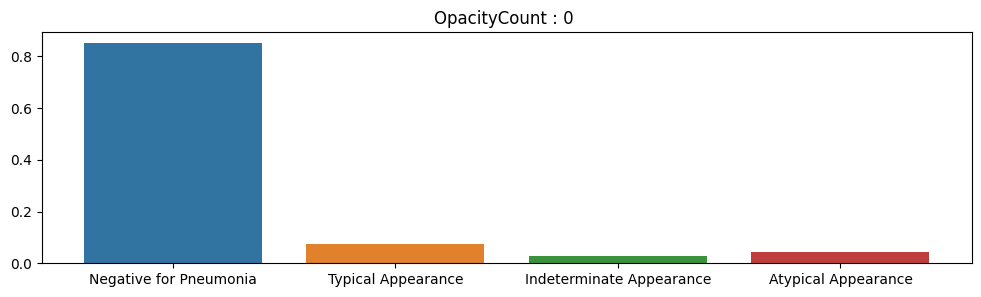

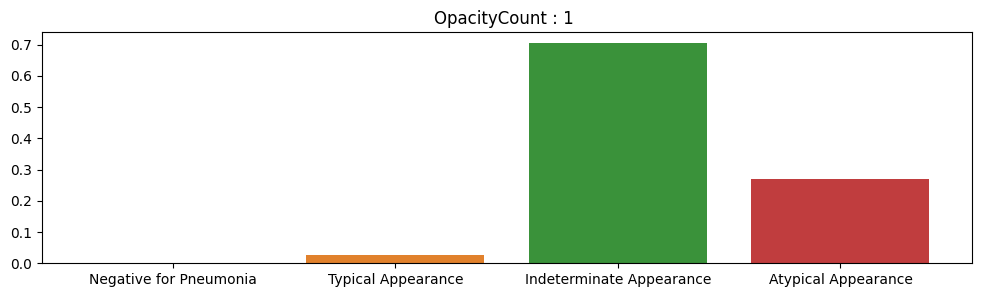

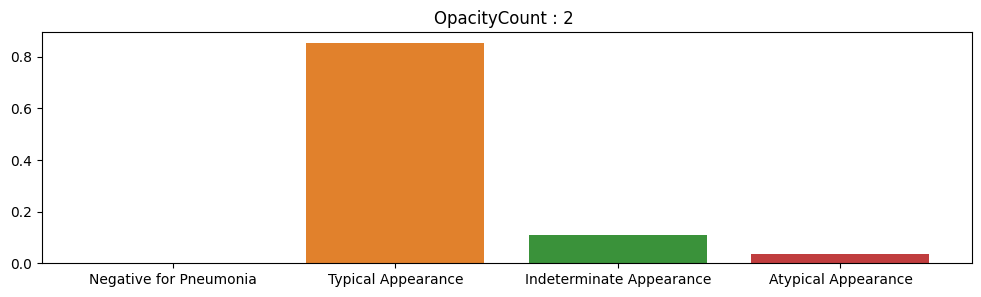

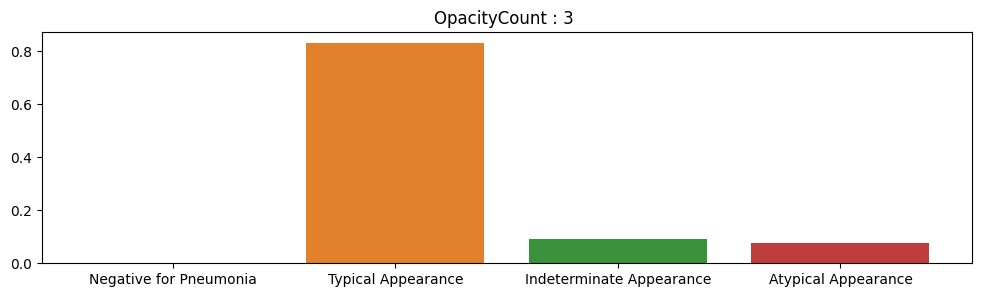

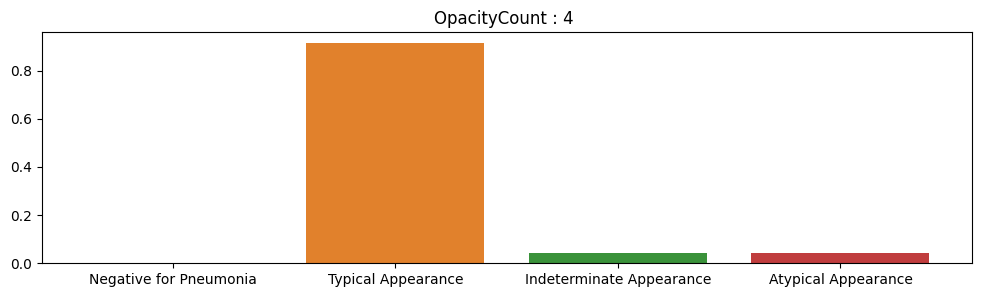

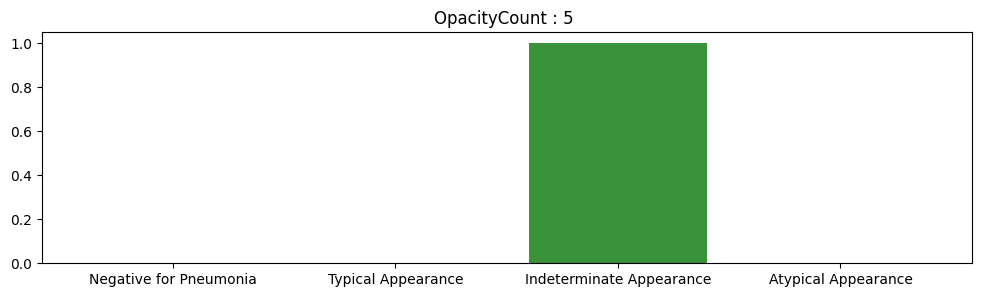

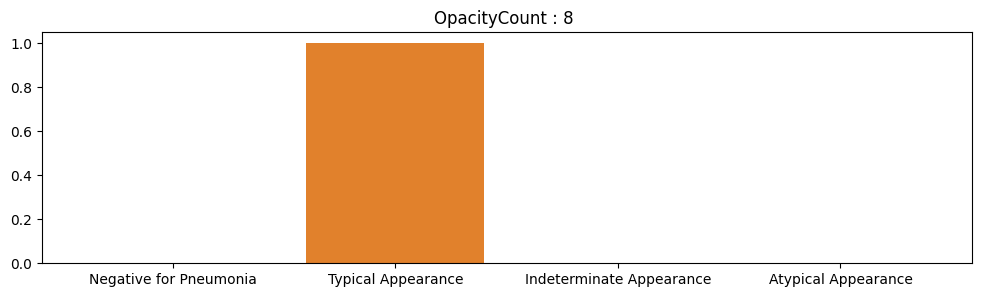

In [86]:
for count in OCount:
    Count_Series = train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum()
    fig = plt.figure(figsize=(12,3))
    sns.barplot(x=Count_Series.index, y=Count_Series.values/sum(train_df['OpacityCount']==count))
    plt.title('OpacityCount : {} '.format(count))
    plt.plot();

In [87]:
sum(train_df['OpacityCount']==1)

973

In [88]:
train_df[(train_df['OpacityCount']==1)&(train_df['Indeterminate Appearance'] == 1)]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
5,0022227f5adf_image,"[{'x': 1857.2065, 'y': 508.30565, 'width': 376...",opacity 1 1857.2065 508.30565 2233.23384 907.8...,84543edc24c2,1,0,0,1,0
18,00a129830f4e_image,"[{'x': 496.23799, 'y': 1175.83357, 'width': 61...",opacity 1 496.23799 1175.83357 1113.61823 1840...,3a3c198051f0,1,0,0,1,0
40,012f57190f1d_image,"[{'x': 1440.88577, 'y': 1319.0304, 'width': 39...",opacity 1 1440.88577 1319.0304 1838.2981200000...,20eb74deaf29,1,0,0,1,0
43,014a736182d3_image,"[{'x': 1020.40636, 'y': 1463.8484, 'width': 10...",opacity 1 1020.40636 1463.8484 2091.12218 2373...,a33697e797cc,1,0,0,1,0
45,015169fc4212_image,"[{'x': 433.38881, 'y': 835.2, 'width': 641.866...",opacity 1 433.38881 835.2 1075.25548 2238.8,528aca245f9a,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
6295,fe6a2dcda2da_image,"[{'x': 2128.61914, 'y': 1797.93075, 'width': 5...",opacity 1 2128.61914 1797.93075 2691.894039999...,7902e534869e,1,0,0,1,0
6296,fe6cd1fbae72_image,"[{'x': 1870.92927, 'y': 1410.89292, 'width': 4...",opacity 1 1870.92927 1410.89292 2311.73481 195...,bf21ae96901c,1,0,0,1,0
6298,fe7fd0793fb3_image,"[{'x': 723.8129, 'y': 918.02781, 'width': 481....",opacity 1 723.8129 918.02781 1204.824250000000...,07a2358b4e59,1,0,0,1,0
6299,fe829429edc4_image,"[{'x': 1968.89074, 'y': 1397.96122, 'width': 7...",opacity 1 1968.89074 1397.96122 2762.55224 191...,aa4b16d18061,1,0,0,1,0


In [89]:
train_df[(train_df['OpacityCount']==1)&(train_df['Atypical Appearance'] == 1)]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1
16,008ca392cff3_image,"[{'x': 2284.17508, 'y': 1342.64878, 'width': 1...",opacity 1 2284.17508 1342.64878 3307.2952 2708...,39a80a14bfda,1,0,0,0,1
124,0449b62bc0b6_image,"[{'x': 1738.0842, 'y': 491.24506, 'width': 764...",opacity 1 1738.0842 491.24506 2502.94284 1838....,b66a03d385b2,1,0,0,0,1
155,051c0c15073e_image,"[{'x': 941.21661, 'y': 677.75974, 'width': 525...",opacity 1 941.21661 677.75974 1466.62181999999...,b65e52a96289,1,0,0,0,1
197,06f4f2f03a93_image,"[{'x': 1862.59153, 'y': 1748.35, 'width': 593....",opacity 1 1862.59153 1748.35 2456.551529999999...,1073d1b6ddcc,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
6203,fa9ccef257cf_image,"[{'x': 1976.45833, 'y': 1439.31252, 'width': 1...",opacity 1 1976.45833 1439.31252 2148.70821 165...,f871e115903e,1,0,0,0,1
6219,fb832b7cf730_image,"[{'x': 855.37671, 'y': 922.90918, 'width': 340...",opacity 1 855.37671 922.90918 1195.37671 1690....,690a40dcd44c,1,0,0,0,1
6220,fb8e258af5e3_image,"[{'x': 597.48772, 'y': 1063.96189, 'width': 56...",opacity 1 597.48772 1063.96189 1167.4674 1844....,a27ab5ca843e,1,0,0,0,1
6300,fe94f73e3072_image,"[{'x': 2887.40002, 'y': 1557.86664, 'width': 1...",opacity 1 2887.40002 1557.86664 3987.40002 231...,9945a45c802e,1,0,0,0,1


In [90]:
train_df[(train_df['OpacityCount']==1)&(train_df['Typical Appearance'] == 1)]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
369,0c65c1436864_image,"[{'x': 1915.58278, 'y': 633.59996, 'width': 65...",opacity 1 1915.58278 633.59996 2572.43263 1730...,c6e1b0f07d2b,1,0,1,0,0
478,10b1352bfe36_image,"[{'x': 779.02392, 'y': 1484.38274, 'width': 79...",opacity 1 779.02392 1484.38274 1578.3349600000...,7adea6f20461,1,0,1,0,0
566,13b742f56244_image,"[{'x': 1594.34016, 'y': 422.96599, 'width': 58...",opacity 1 1594.34016 422.96599 2178.28572 1341...,ce61060be9c9,1,0,1,0,0
603,14fe3a3839c0_image,"[{'x': 521.29667, 'y': 1306.27967, 'width': 51...",opacity 1 521.29667 1306.27967 1040.22971 2028...,b2b9fffd2865,1,0,1,0,0
711,1a0a148c030f_image,"[{'x': 900.71579, 'y': 1330.48801, 'width': 61...",opacity 1 900.71579 1330.48801 1517.76468 1982...,49374ea79cdd,1,0,1,0,0
830,1e9fe71f89bf_image,"[{'x': 589.73334, 'y': 1758.20001, 'width': 10...",opacity 1 589.73334 1758.20001 1597.73334 2914...,48115244cd07,1,0,1,0,0
891,20cde26bb6ff_image,"[{'x': 625.48512, 'y': 735.50068, 'width': 289...",opacity 1 625.48512 735.50068 915.112320000000...,a567703dcd4c,1,0,1,0,0
1069,27bd4ea4ed28_image,"[{'x': 236.25646, 'y': 1720.09565, 'width': 81...",opacity 1 236.25646 1720.09565 1052.94544 2099...,a5303f2a4c73,1,0,1,0,0
1319,31b0dc31da93_image,"[{'x': 1763.60719, 'y': 886.20993, 'width': 80...",opacity 1 1763.60719 886.20993 2572.09534 1810...,29cd2e8cd19c,1,0,1,0,0
1387,33cc8e10ccb0_image,"[{'x': 829.37512, 'y': 1011.77033, 'width': 37...",opacity 1 829.37512 1011.77033 1205.64111 1645...,9fa2ca50548e,1,0,1,0,0


In [91]:
len(train_df[(train_df['OpacityCount']==1)&(train_df['Indeterminate Appearance'] == 1)]) + len(train_df[(train_df['OpacityCount']==1)&(train_df['Atypical Appearance'] == 1)]) + len(train_df[(train_df['OpacityCount']==1)&(train_df['Typical Appearance'] == 1)])

973

In [92]:
sum(train_df['OpacityCount']==1)

973

In [93]:
sample_submission

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1
...,...,...
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1


In [ ]:
# train_df vs train_study

In [94]:
train_study

,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f,0,1,0,0
6050,ffe4d6e8fbb0,0,1,0,0
6051,ffe94fcb14fa,0,1,0,0
6052,ffebf1ef4a9c,0,1,0,0


In [95]:
train_image

,id,boxes,label,StudyInstanceUID,OpacityCount
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2
...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,3
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,2


In [96]:
train_df

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,0,1,0,0,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,3,0,1,0,0
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,2,0,1,0,0


In [97]:
len(train_df['StudyInstanceUID'])

6334

In [98]:
len(train_df['StudyInstanceUID'].unique())

6054

In [ ]:
# 복제 여부

In [99]:
train_image['StudyInstanceUID'].unique().sort() == train_study['StudyInstanceUID'].unique().sort()

True

In [100]:
len(train_image['StudyInstanceUID'].unique())

6054

In [101]:
train_image[train_image.duplicated(['StudyInstanceUID'])==True]['StudyInstanceUID']

156     0fd2db233deb
289     a0254bf8a96e
346     74ba8f2badcb
459     bc3e2b05a7f1
551     0fd2db233deb
            ...     
6191    76b5e2db22ba
6194    abd0c3d9c5f6
6210    2edd69dd0934
6217    350cd603e64d
6239    77539184cdaf
Name: StudyInstanceUID, Length: 280, dtype: object

In [102]:
du_StudyId = train_image[train_image.duplicated(['StudyInstanceUID'])==True]['StudyInstanceUID'].values

In [103]:
du_images = train_image[train_image['StudyInstanceUID'].isin(du_StudyId)].sort_values(by=['StudyInstanceUID'])
du_images

,id,boxes,label,StudyInstanceUID,OpacityCount
2862,74077a8e3b7c_image,"[{'x': 2175.24285, 'y': 1123.72368, 'width': 4...",opacity 1 2175.24285 1123.72368 2607.50603 162...,00f9e183938e,3
2490,6534a837497d_image,NaN,none 1 0 0 1 1,00f9e183938e,0
2119,55e22c0c5de0_image,"[{'x': 455.99999, 'y': 1480.00008, 'width': 26...",opacity 1 455.99999 1480.00008 722.39998 2437....,0142feaef82f,1
6061,f5451a98d684_image,NaN,none 1 0 0 1 1,0142feaef82f,0
3880,9e4824fcee2e_image,"[{'x': 817.77961, 'y': 1075.34501, 'width': 64...",opacity 1 817.77961 1075.34501 1467.08961 2075...,0369e0385796,2
...,...,...,...,...,...
1600,4123a71d9796_image,"[{'x': 889.45144, 'y': 282.39441, 'width': 825...",opacity 1 889.45144 282.39441 1714.51125 1585....,fc45007f145a,2
827,218bcf950372_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6,0
5735,e6cc65d9de1d_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6,0
3277,84ed5f7f71bf_image,"[{'x': 1721.27651, 'y': 974.09667, 'width': 12...",opacity 1 1721.27651 974.09667 2999.21998 2681...,ffcb4630f46f,2


In [105]:
train_df[train_df['StudyInstanceUID'].str.contains('74ba8f2')]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
25,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
27,93a881fb3292_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
28,cdd9e3aaf45a_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0


In [116]:
def error_processed_extraction(i):
    long_path = path + 'train/' + train_df.loc[i, 'StudyInstanceUID'] + '/'
    img_id = train_df.loc[i, 'id'].replace('_image','.dcm')
    for dcm in os.listdir(long_path):
        dcm_path = long_path+dcm+'/'
        if img_id == os.listdir(dcm_path)[0]:
            data_file = dicom.dcmread(dcm_path+img_id)
            print('index : {} - DCM File Path :{}'.format(i, dcm_path+img_id))
        else:
            continue

    img = data_file.pixel_arraylo
    return img

In [109]:
# visualize X-ray with bbox

In [117]:
OpacityType = list(train_df.iloc[:,5:].columns)
OpacityType

['Negative for Pneumonia',
 'Typical Appearance',
 'Indeterminate Appearance',
 'Atypical Appearance']

In [118]:
train_df[train_df[OpacityType[0]]==1]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0
6,0023f02ae886_image,NaN,none 1 0 0 1 1,2fa400b873f5,0,1,0,0,0
25,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
27,93a881fb3292_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
6322,ff7659762b75_image,NaN,none 1 0 0 1 1,4aa11ef1fd38,0,1,0,0,0
6324,ff9f10a24c27_image,NaN,none 1 0 0 1 1,a937614104e3,0,1,0,0,0
6325,ffa9fef3c7bf_image,NaN,none 1 0 0 1 1,5133bbb7b75c,0,1,0,0,0
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0


In [119]:
Negative_Idx = list(train_df[train_df[OpacityType[0]]==1].index)
Negative_Idx[:9]

[1, 6, 25, 26, 27, 28, 30, 34, 35]

In [113]:
train_df.iloc[Negative_Idx, :]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0
6,0023f02ae886_image,NaN,none 1 0 0 1 1,2fa400b873f5,0,1,0,0,0
25,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
27,93a881fb3292_image,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
6322,ff7659762b75_image,NaN,none 1 0 0 1 1,4aa11ef1fd38,0,1,0,0,0
6324,ff9f10a24c27_image,NaN,none 1 0 0 1 1,a937614104e3,0,1,0,0,0
6325,ffa9fef3c7bf_image,NaN,none 1 0 0 1 1,5133bbb7b75c,0,1,0,0,0
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0


FileNotFoundError: ignored

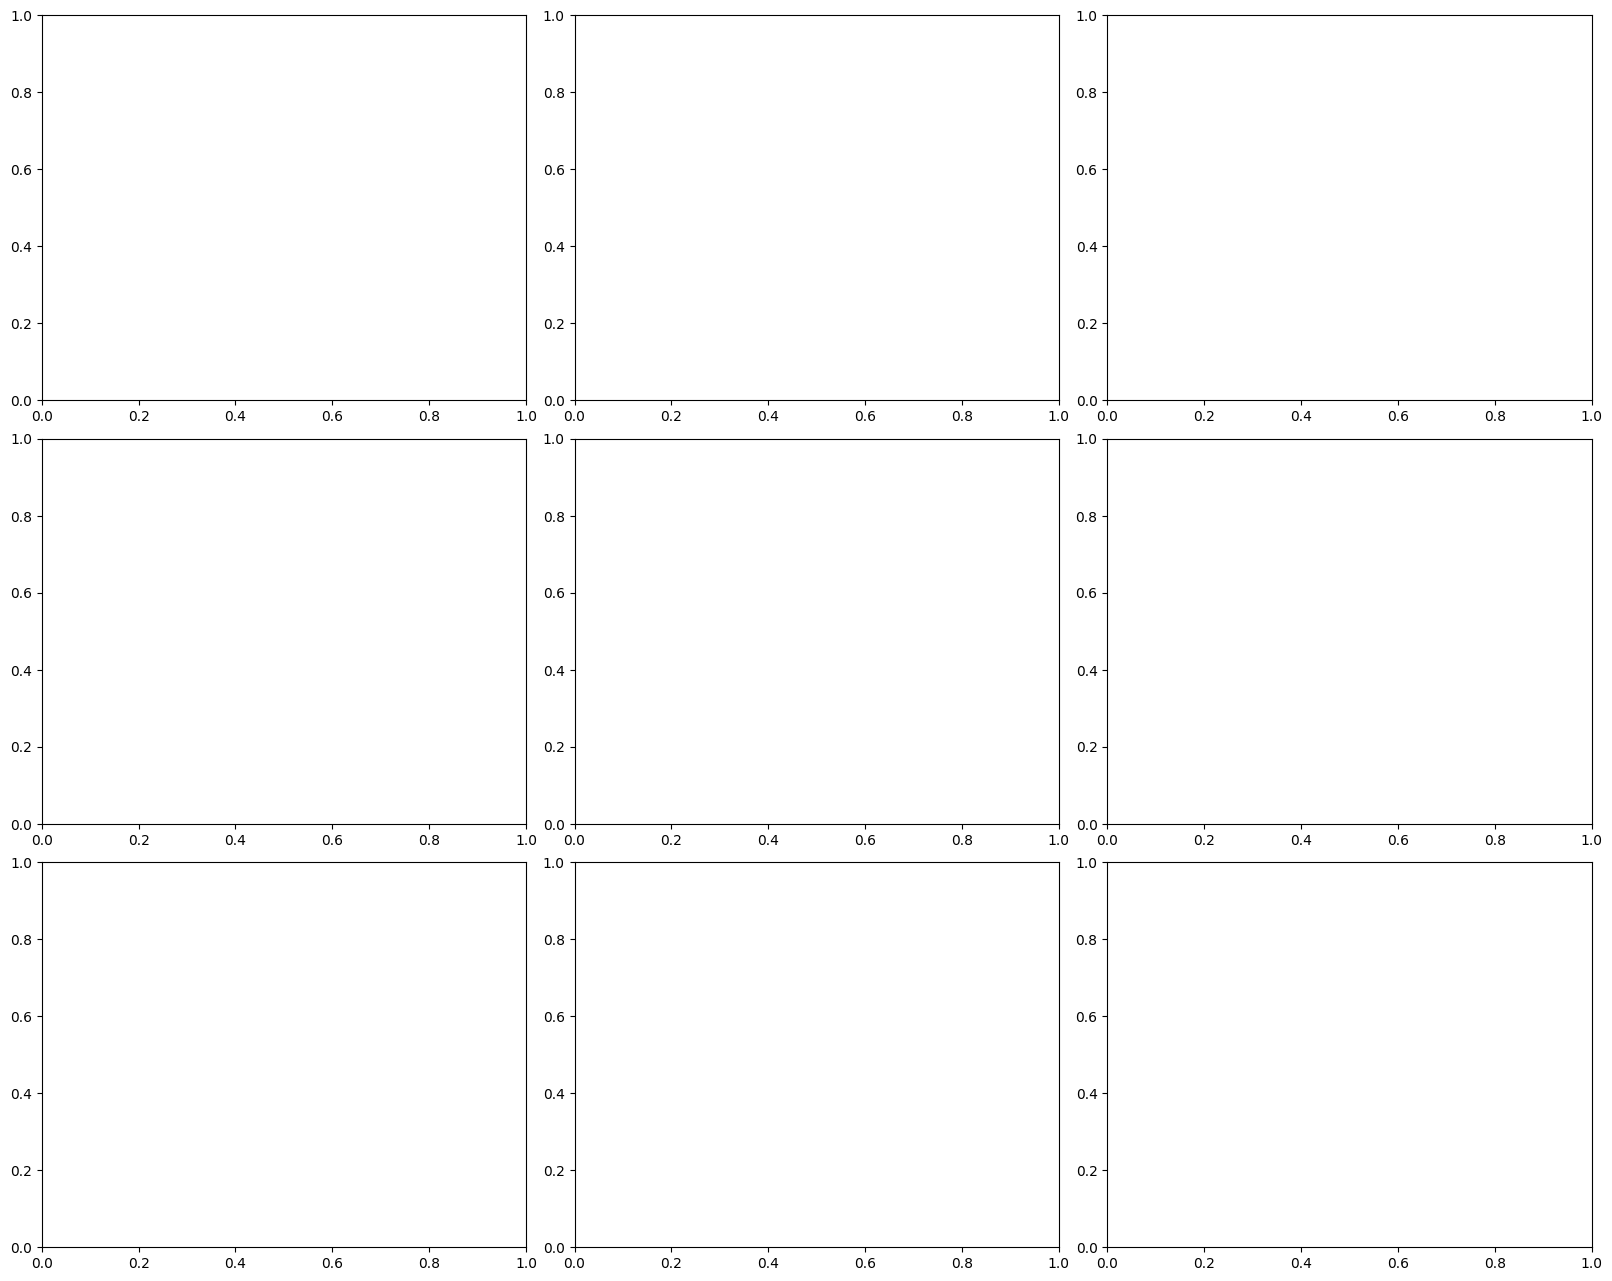

In [120]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Negative_Idx[:9]:
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)

    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(str(train_df.loc[idx, 'label'].split(' ')[0])+ str(idx))
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1